# Prediction of the KS system: a model using Feed-Forwark Neural Network

 In this notebook, I will use a simple model of Deep Learning to predict the KS system. More precisely, we wanna predict the next step of a given state of the system. To do it, a simple feed-forward neural network will be used.
It is just the first model trained to predict the system. I will try many configurations and varieties.

To generate the data, I will use the KS.py code provided by Alessandro Bucci.

In [0]:
import numpy as np
import torch as th
import time
from KS import KS
import matplotlib.pyplot as plt

First, let's set the parameters of the simulation:

In [0]:
Tend = 1000 # the total time of the simulation
dt = 0.1 # the time step 
L=20 # the "physical" length of the domaine. pay attention cuz this value will determine if the system is regular or chaotic
N=64 # the number of sample points on this length. It will be the size of the input in our system
observation = np.loadtxt('u1.dat') #the observed initial state of the system

Let's run the simulation to generate the data:

In [5]:
ks = KS(L=L,N=N,dt=dt) #class of the simulation
TotalTime= int(np.round(Tend/dt))
print("Running for : ",TotalTime, 'seconds')
taxis = 0 
action = np.zeros(1) #I don't know what is this exactly
U = np.matrix(observation) # We will stack in U at each time step

for nt in range(TotalTime): 
    observation = ks.advance(observation,action)
    U = np.vstack((U,observation))
    taxis = np.hstack((taxis,(nt+1)*ks.dt))

# Explore the results 
print('The U shape is:', U.shape)
print('The final time:', taxis[-1])

Running for :  10000 seconds
The U shape is: (10001, 64)
The final time: 1000.0


Separating the data into training and test sets:

In [0]:
X = U[:-1,:] #our input: all the data excluding the last one
Y = U[1:,:] #our output: all the data minus the first one

NN=U.shape[0]-1
Nt = int(NN*0.9) # number of train
Nv = int(NN*0.1) # number of validation
np.random.seed(0)

seq=np.arange(X.shape[0])
np.random.shuffle(seq)
train_seq=seq[0:Nt]
valid_seq=seq[-Nv:]
X_train = X[train_seq]
Y_train = Y[train_seq]
X_valid = X[valid_seq]
Y_valid = Y[valid_seq]
X_train_th = th.from_numpy(X_train).cuda()
Y_train_th = th.from_numpy(Y_train).cuda()
X_valid_th = th.from_numpy(X_valid).cuda()
Y_valid_th = th.from_numpy(Y_valid).cuda()

# Training:

In [0]:
def train(model,X_train,X_valid,Y_train,Y_valid,epochs=30,batch_size=64):
    Nt=len(X_train)
    Nv=len(X_valid)
    ### Mini-batching and shuffle 
    idx = np.arange(Nt)
    nbatch = int(Nt/batch_size)
    train_losses,valid_losses=[],[]
    start_time=time.time()
    print("Epoch\tTrain Loss\tValid Loss")

    #Just to see our random parameters
    model.eval()
    with th.no_grad():
        running_loss=0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            x = X_train[ids]
            ttf_calc=model(x).squeeze()
            ttf = Y_train[ids]
            loss=loss_fn(ttf_calc,ttf)
            running_loss+=loss.item()
        train_losses.append(running_loss/nbatch)
        running_loss=0
        ttf_calc=model(X_valid).squeeze()
        ttf = Y_valid
        loss=loss_fn(ttf_calc,ttf)
        running_loss+=loss.item()
        valid_losses.append(running_loss)            
    for e in range(epochs):
        model.train()
        print("{}\t".format(e),"{:.5f}..\t".format(train_losses[-1]),"{:.5f}..".format(valid_losses[-1]))  
        np.random.shuffle(idx)
        running_loss=0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            x = X_train[ids]
            optimizer.zero_grad()
            ttf_calc=model(x).squeeze()
            ttf = Y_train[ids]
            loss=loss_fn(ttf_calc,ttf)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        # training is over for one epoch
        # now compute interesting quantities
        model.eval()
        train_losses.append(running_loss/nbatch)
        running_loss=0
        with th.no_grad():
            x = X_valid
            ttf_calc=model(x).squeeze()
            ttf = Y_valid
            loss=loss_fn(ttf_calc,ttf)
            running_loss+=loss.item()
            valid_losses.append(running_loss)  
    print("{}\t".format(e+1),"{:.5f}..\t".format(train_losses[-1]),"{:.5f}..".format(valid_losses[-1]))     
    print("---------- Best : {:.3f}".format(min(valid_losses)), " at epoch " 
          , np.fromiter(valid_losses, dtype=np.float).argmin(), " / ",epochs )
    print('Execution time={:.2f}s'.format(time.time()-start_time))
    #plot some graphs
    plt.figure(figsize = (9, 1.5))
    ax= plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    ax.set_ylim(bottom=0)
    ax= plt.subplot(1, 2, 2)
    plt.plot(valid_losses)
    ax.set_ylim(bottom=0)

# Model:

Epoch	Train Loss	Valid Loss
0	 1.07630..	 1.07232..
1	 0.92406..	 0.80736..
2	 0.74119..	 0.67194..
3	 0.64727..	 0.62506..
4	 0.61956..	 0.60078..
5	 0.59232..	 0.57851..
6	 0.58039..	 0.57177..
7	 0.57432..	 0.56658..
8	 0.56877..	 0.56128..
9	 0.56389..	 0.55739..
10	 0.56001..	 0.55389..
11	 0.55654..	 0.55097..
12	 0.55391..	 0.54875..
13	 0.55142..	 0.54660..
14	 0.54907..	 0.54411..
15	 0.54646..	 0.54203..
16	 0.54417..	 0.53941..
17	 0.54144..	 0.53694..
18	 0.53915..	 0.53533..
19	 0.53755..	 0.53396..
20	 0.53610..	 0.53259..
21	 0.53477..	 0.53144..
22	 0.53352..	 0.53030..
23	 0.53233..	 0.52931..
24	 0.53130..	 0.52830..
25	 0.53024..	 0.52741..
26	 0.52937..	 0.52655..
27	 0.52847..	 0.52584..
28	 0.52765..	 0.52515..
29	 0.52694..	 0.52450..
30	 0.52635..	 0.52403..
31	 0.52569..	 0.52347..
32	 0.52524..	 0.52316..
33	 0.52479..	 0.52269..
34	 0.52436..	 0.52227..
35	 0.52396..	 0.52202..
36	 0.52358..	 0.52170..
37	 0.52326..	 0.52140..
38	 0.52302..	 0.52115..
39	 0.5

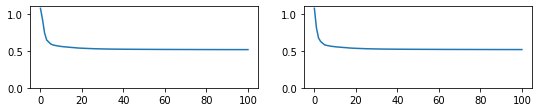

In [10]:
n_input=64
n_output=64
model = th.nn.Sequential(
    th.nn.Linear(n_input,n_output),
    th.nn.LeakyReLU()
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-4)
loss_fn=th.nn.L1Loss()
train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=100,batch_size=64)